In [34]:
from readability import Readability
from readability.exceptions import ReadabilityException
import re
import numpy as np
import math
import nltk
import pandas as pd
import traceback

import seaborn as sns

In [35]:
import mistune
import mistune.renderers

In [36]:
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=32)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['axes.titlesize'] = "xx-large"

In [38]:
#Load the data
import pickle
with open("../data/policy_text_v11.pickle", "rb") as f:
    df = pickle.load(f)

KeyboardInterrupt: 

# Clean up

In [5]:
valid_end_punct = set((".","!","?",'"',"'"))
def strip_incomplete_sentences(text,flag_components=False):
    sentences = nltk.tokenize.sent_tokenize(text)
    if len(sentences) == 0:
        return ""
    words = nltk.tokenize.word_tokenize(sentences[-1])
    if not words[-1] in valid_end_punct:
        if flag_components:
            sentences[-1] = "_cut_" + sentences[-1] + "_cut_"
        else:
            sentences = sentences[:-1]
    return " ".join(sentences)

class StraightTextRenderer(mistune.renderers.BaseRenderer):
    
    def __init__(self,flag_components):
        self.flag_components = flag_components
    
    def text(self, text):
        return text

    def link(self, link, text=None, title=None):
        if text is None:
            return "link"
        else:
            return text

    def image(self, src, alt="", title=None):
        return ""

    def emphasis(self, text):
        return text

    def strong(self, text):
        return text

    def codespan(self, text):
        if self.flag_components:
            return "\n_codespan_%s_codespan\n" % text
        else:
            return "\n"

    def linebreak(self):
        if self.flag_components:
            return "\n_line break_\n"
        else:
            return "\n"

    def inline_html(self, html):
        if self.flag_components:
            return '\n_inline-html_%s_inline-html_\n' % html
        else:
            #HTML isn't prose
            return "\n"

    def paragraph(self, text):
        if text == '': return text
        paragraphs = text.split('\n')
        paragraphs = (strip_incomplete_sentences(para,flag_components=self.flag_components) for para in paragraphs)
        text = "\n".join(paragraphs)
        if self.flag_components:
            return "\n_paragraph_\n" + text + "\n_paragraph_\n"
        else:
            return text + "\n"

    def heading(self, text, level):
        if self.flag_components:
            return '\n_heading %d_ %s\n' % (level,text)
        else:
            #Headings aren't prose
            return "\n"

    def newline(self):
        if self.flag_components:
            return '\n_newline_\n'
        else:
            return "\n"

    def thematic_break(self):
        if self.flag_components:
            return '\n_thematic-break_\n'
        else:
            return "\n"

    def block_text(self, text):
        if self.flag_components:
            return '\n_block-text_%s_block-text_\n' % text
        else:
            return "%s\n" % text

    def block_code(self, code, info=None):
        if self.flag_components:
            if not code.strip():
                return "\n"
            else:
                return '\n_block-code_%s_block-code_\n' % code
        else:
            #This stuff usually isn't code, treat it as a paragraph
            return self.paragraph(code)

    def block_quote(self, text):
        if self.flag_components:
            return '\n_block-quote_%s_block-quote_\n' % text
        else:
            return "%s\n" % text

    def block_html(self, html):
        if self.flag_components:
            return "\n_block-html_%s_block-html\n" % html
        else:
            #HTML isn't prose
            return  "\n"

    def block_error(self, html):
        if self.flag_components:
            return "\n_block-error_%s_block-error\n" % html
        else:
            #Errors aren't prose
            return "\n"

    def list(self, text, ordered, level, start=None):
        if text == '': return text
        paragraphs = text.split('\n')
        paragraphs = [strip_incomplete_sentences(para,flag_components=self.flag_components) for para in paragraphs]
        text = "\n".join(paragraphs)
        if self.flag_components:
            return "\n_list %s %d_\n%s\n_list_\n" % (ordered, level, text)
        else:
            #Lists are inconsistent in how many sentences they represent
            #Rule: If all of the rows are sentences, then we'll keep them
            #If any stripped list item is empty, return empty for everything
            if any((not list_item.strip() for list_item in paragraphs)):
                return "\n"
            else:
                return text + "\n"

    def list_item(self, text, level):
        return "%s\n" % text
    
    def strikethrough(self, text):
        return ""
    
    def table(self, text):
        if self.flag_components:
            return '\n_table_%s_table_\n' % (text)
        else:
            return "\n"
    
    def table_cell(self, content, align=None, is_head=False):
        if self.flag_components:
            return '\n_cell_\n'
        else:
            return ""
    
    def table_head(self, content):
        if self.flag_components:
            return '\n_head_\n'
        else:
            return ""
        
    def table_row(self, content):
        if self.flag_components:
            return '_row_%s_row_\n' % content
        else:
            return ""
        
    def table_body(self, content):
        if self.flag_components:
            return '_body_%s_body_\n' % content
        else:
            return ""
    
markdown = mistune.create_markdown(renderer=StraightTextRenderer(False))
markdown_debug = mistune.create_markdown(renderer=StraightTextRenderer(True))

#Install mistune plugins
import mistune.plugins
mistune.plugins.plugin_table(markdown)
mistune.plugins.plugin_strikethrough(markdown)
mistune.plugins.plugin_table(markdown_debug)
mistune.plugins.plugin_strikethrough(markdown_debug)

def clean(policy_text):
    return markdown(policy_text)

def clean_debug(policy_text):
    return markdown_debug(policy_text)

In [6]:
def get_readability(policy_text):
    fk = Readability(clean(policy_text)).flesch_kincaid()
    return fk.score

In [16]:
def get_readability_ease(policy_text):
    try:
        fk = Readability(clean(policy_text)).flesch()
        return fk.score
    except ReadabilityException:
        return None

In [8]:
def compare_readability(policy_text):
    fk1 = Readability(policy_text).flesch_kincaid()
    s1 = fk1.score
    try:
        fk2 = Readability(clean(policy_text)).flesch_kincaid()
        s2 = fk2.score
    except ReadabilityException:
        s2 = None
    return s1, s2

In [ ]:
df["flesch_ease_c"] = df.policy_text.apply(get_readability_ease)

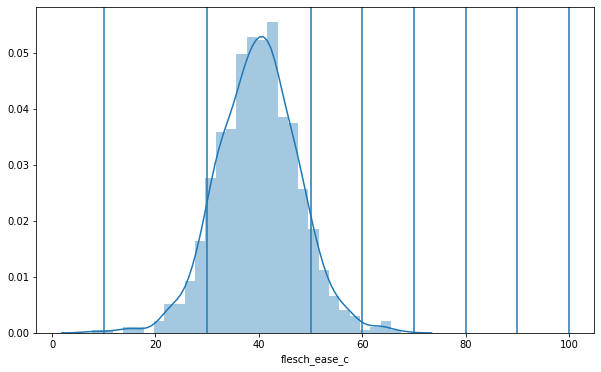

In [32]:
kwargs = {"cumulative":True}
fig = sns.distplot(df.flesch_ease_c.sample(1000))
fig.axvline(10)
fig.axvline(30)
fig.axvline(50)
fig.axvline(60)
fig.axvline(70)
fig.axvline(80)
fig.axvline(90)
fig.axvline(100)

In [ ]:
df_sample = df[df.flesch_kincaid.notnull()].sample(1000)

In [ ]:
def compare_row_readability(row):
    site_url = row.site_url
    year = row.year
    season = row.season
    try:
        before, after = compare_readability(row.policy_text)
    except KeyboardInterrupt:
        raise
    except:
        print(site_url,year,season)
        traceback.print_exc()
        before = after = math.nan
    return pd.Series({"site_url":site_url, "year":year,"season":season,"before":before,"after":after})

#Extract subset with excessively high scores
df_high = df_sample[df_sample.flesch_kincaid.notnull() & (df_sample.flesch_kincaid > 20)].sort_values("flesch_kincaid",axis=0)
print(len(df_high))
df_scores = df_sample.apply(compare_row_readability,axis=1)
#df_scores = df_scores[df_scores.before.notnull()]
df_scores

In [ ]:
df_scores[df_scores.after.notnull()]

In [ ]:
df_scores[df_scores.after > 20]

In [ ]:
def cumulative_graph(series,label):
    counts = series[series.notnull()].sort_values()
    #xs = sorted(list(set(counts)))
    xs = sorted(list(counts))
    ys = []
    cumulative = 0
    for count in counts:
        cumulative += 1
        ys.append(cumulative)
    plt.plot(xs,ys,label=label)

In [ ]:
df_high_scores = df_scores[df_scores.before > 20]
cumulative_graph(df_scores.before,"before")
cumulative_graph(df_scores.after,"after")
plt.legend()
#plt.xscale("log")
plt.xlim(0,25)
pass

In [ ]:
print(len(df_scores[df_scores.after.isnull()]))
print(df_scores[df_scores.after.isnull()])
s = df_scores[df_scores.after.isnull()].sample(1).iloc[0]

In [ ]:
df_sample = df[df.flesch_kincaid.notnull()].sample(10000)


In [ ]:
def has_code_block(row):
    site_url = row.site_url
    year = row.year
    season = row.season
    try:
        cleaned = clean_debug(row.policy_text)
        block_code = "_block-code_" in cleaned
        inline_html = "_inline-html_" in cleaned
        codespan = "_codespan_" in cleaned
        block_html = "_block-html_" in cleaned
    except KeyboardInterrupt:
        raise
    except:
        print(site_url,year,season)
        traceback.print_exc()
        block_code = False
        inline_html = False
        codespan = False
        block_html = False
    return pd.Series({"site_url":site_url, "year":year,"season":season,"block_code": block_code,
                      "block_html":block_html, "codespan": codespan, "inline_html":inline_html})

df_cleaned = df_sample.apply(has_code_block,axis=1)

In [ ]:
print("%s %d%s %f -> %f" % (s.site_url, s.year, s.season, s.before, s.after))
print(clean_debug(df[(df.site_url==s.site_url) & (df.year==s.year) & (df.season == s.season)].policy_text.iat[0]))

In [ ]:
dys = "http://fununltd.net 2015B".split(" ")
site_url = dys[0]
year = int(dys[1][:4])
season = dys[1][4]

policy_text = df[(df.site_url==site_url) & (df.year==year) & (df.season == season)].policy_text.iat[0]

before,after = compare_readability(policy_text)
if before == None:
    before = math.nan
if after == None:
    after = math.nan
print("%s %d%s %f -> %f" % (site_url,year,season,before,after))

print(clean_debug(policy_text))

In [ ]:
df_cleaned

In [ ]:
df_cleaned[df_cleaned.inline_html]

In [ ]:
df_cleaned[df_cleaned.block_code]

In [ ]:
df_cleaned[df_cleaned.block_html]

In [ ]:
df_cleaned[df_cleaned.codespan]

In [ ]:
def print_policies(df_source):
    if len(df_source) > 10:
        df_source = df_source.sample(10)
    for i in range(len(df_source)):
        s = df_source.iloc[i]
        print("%s %d%s" % (s.site_url, s.year, s.season))

        print(df[(df.site_url==s.site_url) & (df.year==s.year) & (df.season == s.season)].policy_text.iat[0])

        print("------------------------------------------------------------------------------------------------")
    
        print(clean_debug(df[(df.site_url==s.site_url) & (df.year==s.year) & (df.season == s.season)].policy_text.iat[0]))
        
        print("================================================================================================")

In [ ]:
print_policies(df_cleaned[df_cleaned.block_code])

In [ ]:
print_policies(df_cleaned[df_cleaned.codespan])

In [ ]:
print_policies(df_cleaned[df_cleaned.inline_html])

In [ ]:
print_policies(df_cleaned[df_cleaned.block_html])

In [ ]:
df_with_blocks = df_cleaned[df_cleaned.block_code].apply(lambda s: df[(df.site_url==s.site_url) & (df.year==s.year) & (df.season == s.season)].iloc[0], axis=1)

In [ ]:
df_with_blocks

In [ ]:
df_blocks_score = df_with_blocks.apply(compare_row_readability,axis=1)

In [ ]:
df_blocks_score[df_blocks_score.after.notnull()]